# DELAYED FLIGHTS IN THE US: A Painful Reality 
## *Author: Jean-Philippe Pitteloud*

Have you ever experience a long and uncertain wait in a crowded airport without knowing if you are going to make it home, or your vacation, or your work meeting ? You are probably not alone in this group that typically have no other option but to patiently wait until the gates are finally open and the crew ready to scan your boarding pass. This work is inspired by a recent event that almost ruined a pleasant long weekdend in San Juan, Puerto Rico. What started as a fun trip to this beatiful island, slowly changed into a very painful experience for my family. A flight that was supposed to leave at 8:30 PM in the evening ended up leaving at 2:30 AM. The long wait was horrific, 2 hours inside a plane without A/C probably resembled more a torture than a pleasure. Since my intention is not to bore you with a story that may be millions can share, I decided to know a little bit more about the behind-the-scenes of flight delays.

### Requirements

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, fnmatch
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline

### Data Gathering

In order to assemble our master dataset comprising information for the period of 2014-2018, a built-in function available in the 'OS' library was employed. First, the corresponding files for each year were manually downloaded from the United States Department of Transportation website (Bureau of Transportation Statistics, https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1). After storing each separate file in a working directory, a list of files was created and a loop used to read and append the data to a dataframe named 'df_master'.

In [2]:
# a sorted list of the .csv files present in the working directory was created
file_list = sorted(list(filter(lambda x: '.csv' in x, os.listdir('.'))))

In [3]:
df_master = pd.DataFrame()
for i in range(0, len(file_list)):
    if df_master.empty: #evaluate if the 'comb_df' dataframe is empty
        df_master = pd.read_csv(file_list[i]) #if empty, the dataframe resulting from 'prepare_data' is stored
        i += 1 #increasing the indexing figure to move to the next file
    else:
        # if dataframe is not empty, merge new dataframe from 'prepare_data' to existing 'comb_df' dataframe
        df_master = df_master.append(pd.read_csv(file_list[i]), ignore_index = True)
        i += 1

### Data Assessment and Cleaning

Visual assessment of the dataset revealed a quite complete dataset with a diverse range of fields that include carrier and airport information, and a myriad of fields reporting the count of flights delayed and some of the most common reasons for their delays. Also, count of minutes delayed for each of those reasons is reported. The master dataset, is composed of 72,474 records of airlines during the period between January, 2014 and December, 2018.

In [4]:
print('Number of records on the master dataset:', df_master.shape[0])

Number of records on the master dataset: 72600


The master dataset is divided into 23 columns. To avoid any confusion with the titles of the columns, some of the fields were appropriately renamed to be more explicit.

In [5]:
df_master.rename(columns = {'arr_flights': 'total_flights', ' arr_delay': 'tot_min_delay', 'arr_del15': 'delayed_flights', 'arr_diverted': 'diverted_flights', 'arr_cancelled': 'cancelled_flights', ' carrier_delay': 'min_carrier_delay', 'weather_delay': 'min_weather_delay', 'nas_delay': 'min_nas_delay', 'security_delay': 'min_security_delay', 'late_aircraft_delay': 'min_late_aircraft_delay', 'carrier_ct': 'del_carrier_ct', ' weather_ct': 'del_weather_ct', 'nas_ct': 'del_nas_ct', 'security_ct': 'del_security_ct', 'late_aircraft_ct': 'del_late_aircraft_ct', ' month': 'month'}, inplace = True)

Although the data in the field 'airport_name' includes the city and state where the aiport is located, the two letter state abbreviation was extracted to facilitate future aggregation of the data using the state as reference.

In [6]:
states = df_master.airport_name.str.extract(r'([A-Z][A-Z])')
df_master = df_master.merge(states, left_index = True, right_index = True)

df_master.rename(columns = {0: 'state'}, inplace = True)

In [7]:
df_master.head()

,year,month,carrier,carrier_name,airport,airport_name,total_flights,delayed_flights,del_carrier_ct,del_weather_ct,...,cancelled_flights,diverted_flights,tot_min_delay,min_carrier_delay,min_weather_delay,min_nas_delay,min_security_delay,min_late_aircraft_delay,Unnamed: 21,state
0,2014,1,AA,American Airlines Inc.,JFK,"New York, NY: John F. Kennedy International",1139.0,233.0,68.65,11.21,...,74.0,13.0,15754.0,3957.0,1575.0,3431.0,0.0,6791.0,NaN,NY
1,2014,1,AA,American Airlines Inc.,LAX,"Los Angeles, CA: Los Angeles International",2595.0,452.0,132.37,74.77,...,62.0,3.0,25283.0,7552.0,4600.0,4232.0,4.0,8895.0,NaN,CA
2,2014,1,AA,American Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",13135.0,2185.0,505.52,133.75,...,295.0,17.0,137289.0,49667.0,10471.0,18417.0,15.0,58719.0,NaN,TX
3,2014,1,AA,American Airlines Inc.,OGG,"Kahului, HI: Kahului Airport",92.0,20.0,9.57,0.00,...,0.0,0.0,812.0,563.0,0.0,230.0,0.0,19.0,NaN,HI
4,2014,1,AA,American Airlines Inc.,HNL,"Honolulu, HI: Daniel K Inouye International",176.0,50.0,14.46,5.65,...,0.0,1.0,2565.0,844.0,238.0,646.0,0.0,837.0,NaN,HI


In order to get information about the integrity and quality of the data, information about the formatting and the completeness of each field was retrieved. As it can be seen below, most of the fields are quite complete except the last field named 'Unnamed: 21'. Also, a very small percentage (< 0.1%) of missing records is reported in some of the remaining fields.

In [8]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72600 entries, 0 to 72599
Data columns (total 23 columns):
year                       72600 non-null int64
month                      72600 non-null int64
carrier                    72600 non-null object
carrier_name               72600 non-null object
airport                    72600 non-null object
airport_name               72600 non-null object
total_flights              72520 non-null float64
delayed_flights            72505 non-null float64
del_carrier_ct             72520 non-null float64
del_weather_ct             72520 non-null float64
del_nas_ct                 72520 non-null float64
del_security_ct            72520 non-null float64
del_late_aircraft_ct       72520 non-null float64
cancelled_flights          72520 non-null float64
diverted_flights           72520 non-null float64
tot_min_delay              72520 non-null float64
min_carrier_delay          72520 non-null float64
min_weather_delay          72520 non-null float64

Since the field 'Unnamed: 21' is completely empty, the field was removed from the master dataset.

In [9]:
df_master.drop('Unnamed: 21', axis = 1, inplace = True)

In order to address the presence of less than 0.1% of missing records in some of our fields, the best course of action in this particular case is to remove the records containing any missing values from the master dataset.

In [10]:
df_master.dropna(inplace = True)

Upon addressing the presence of missing values from our dataset, the number of records was reduced to 72,379.

In [11]:
print('Number of records after addressing missing values:', df_master.shape[0])

Number of records after addressing missing values: 72505


To make the data more presentable, the order of the fields in our dataset was arranged into a more appropriate format, 

In [12]:
df_master = df_master[['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'state', 'total_flights', 'delayed_flights', 'del_carrier_ct', 'del_weather_ct', 'del_nas_ct', 'del_security_ct', 'del_late_aircraft_ct', 'cancelled_flights', 'diverted_flights', 'tot_min_delay', 'min_carrier_delay', 'min_weather_delay', 'min_nas_delay', 'min_security_delay', 'min_late_aircraft_delay']]

df_master.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'state', 'total_flights', 'delayed_flights', 'del_carrier_ct',
       'del_weather_ct', 'del_nas_ct', 'del_security_ct',
       'del_late_aircraft_ct', 'cancelled_flights', 'diverted_flights',
       'tot_min_delay', 'min_carrier_delay', 'min_weather_delay',
       'min_nas_delay', 'min_security_delay', 'min_late_aircraft_delay'],
      dtype='object')

In an attempt to best compare the performance of different airlines and airports with regards to delays and cancellations of flights, some new features or fields were created from the existing ones. For example, the "percentage of delayed flights" (pct_delayed_flights) can be considered a much better metric than just the "number of delayed flights" (delayed_flights) at the moment of comparing the performance of a small carrier and a large carrier. Based on this logic, multiple new fields were created as described below.

In [13]:
# a series of new features were created from some of the original to provide percetanges and proportions rather than total counts
df_master['pct_delayed_flights'] = (df_master['delayed_flights'] / df_master['total_flights']) * 100
df_master['pct_cancelled_flights'] = (df_master['cancelled_flights'] / df_master['total_flights']) * 100
df_master['pct_diverted_flights'] = (df_master['diverted_flights'] / df_master['total_flights']) * 100
df_master['pct_del_carrier'] = (df_master['del_carrier_ct'] / df_master['delayed_flights']) * 100
df_master['pct_del_weather'] = (df_master['del_weather_ct'] / df_master['delayed_flights']) * 100
df_master['pct_del_nas'] = (df_master['del_nas_ct'] / df_master['delayed_flights']) * 100
df_master['pct_del_security'] = (df_master['del_security_ct'] / df_master['delayed_flights']) * 100
df_master['pct_del_late'] = (df_master['del_late_aircraft_ct'] / df_master['delayed_flights']) * 100
df_master['min_per_delay'] = df_master['tot_min_delay'] / df_master['delayed_flights']

A sample of our cleaned dataset is presented below,

In [14]:
print('The cleaned dataset consists of {} rows and {} columns'.format(df_master.shape[0], df_master.shape[1]))

df_master.sample(5)

The cleaned dataset consists of 72505 rows and 31 columns


,year,month,carrier,carrier_name,airport,airport_name,state,total_flights,delayed_flights,del_carrier_ct,...,min_late_aircraft_delay,pct_delayed_flights,pct_cancelled_flights,pct_diverted_flights,pct_del_carrier,pct_del_weather,pct_del_nas,pct_del_security,pct_del_late,min_per_delay
29114,2016,2,NK,Spirit Air Lines,RSW,"Fort Myers, FL: Southwest Florida International",FL,354.0,126.0,21.59,...,1969.0,35.593220,2.824859,0.564972,17.134921,0.428571,65.047619,0.000000,17.388889,65.714286
63101,2018,7,MQ,Envoy Air,FAY,"Fayetteville, NC: Fayetteville Regional/Granni...",NC,25.0,6.0,1.30,...,0.0,24.000000,8.000000,0.000000,21.666667,12.833333,65.500000,0.000000,0.000000,24.000000
5346,2014,5,MQ,Envoy Air,DCA,"Washington, DC: Ronald Reagan Washington National",DC,580.0,141.0,30.46,...,4525.0,24.310345,5.862069,0.172414,21.602837,1.865248,25.354610,0.113475,51.056738,59.680851
72099,2018,12,UA,United Air Lines Inc.,BDL,"Hartford, CT: Bradley International",CT,174.0,21.0,6.55,...,635.0,12.068966,0.000000,0.000000,31.190476,0.000000,21.238095,0.000000,47.571429,45.809524
37086,2016,10,EV,ExpressJet Airlines Inc.,CWA,"Mosinee, WI: Central Wisconsin",WI,42.0,5.0,0.97,...,117.0,11.904762,0.000000,0.000000,19.400000,0.000000,21.800000,0.000000,58.800000,31.400000


Finally, a look into the summary statistics for the dataset might provide more information about the distribution of the numeric fields.

In [15]:
df_master.describe()

,year,month,total_flights,delayed_flights,del_carrier_ct,del_weather_ct,del_nas_ct,del_security_ct,del_late_aircraft_ct,cancelled_flights,...,min_late_aircraft_delay,pct_delayed_flights,pct_cancelled_flights,pct_diverted_flights,pct_del_carrier,pct_del_weather,pct_del_nas,pct_del_security,pct_del_late,min_per_delay
count,72505.000000,72505.000000,72505.000000,72505.000000,72505.000000,72505.000000,72505.000000,72505.000000,72505.000000,72505.000000,...,72505.000000,72505.000000,72505.000000,72505.000000,70748.000000,70748.000000,70748.000000,70748.000000,70748.000000,70748.000000
mean,2016.163271,6.507124,417.198566,78.242466,22.463791,2.430164,24.321352,0.135017,28.892165,6.667057,...,1918.875884,19.203377,1.763340,0.292673,35.725165,3.936467,27.615986,0.187687,32.535806,59.204652
std,1.493389,3.449188,1094.039813,195.069241,49.352208,7.231386,70.936954,0.558802,79.384913,28.425990,...,5365.458134,10.333389,3.351874,1.008620,17.907886,7.020914,18.300916,1.464296,17.233184,28.580177
min,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
25%,2015.000000,4.000000,58.000000,9.000000,2.950000,0.000000,1.790000,0.000000,2.240000,0.000000,...,123.000000,12.500000,0.000000,0.000000,24.963780,0.000000,15.000000,0.000000,21.744085,44.904762
50%,2016.000000,7.000000,120.000000,22.000000,7.760000,0.540000,5.300000,0.000000,6.990000,1.000000,...,445.000000,18.048780,0.486285,0.000000,33.916667,1.416667,25.000000,0.000000,32.326499,55.307751
75%,2018.000000,9.000000,301.000000,58.000000,19.820000,2.000000,15.160000,0.000000,19.340000,4.000000,...,1316.000000,24.561404,2.173913,0.186451,44.368421,5.013490,37.000000,0.000000,43.136755,67.709821
max,2019.000000,12.000000,21977.000000,4176.000000,1242.160000,240.790000,1884.420000,19.530000,1849.000000,1312.000000,...,148181.000000,100.000000,86.666667,66.666667,100.000000,100.000000,100.000000,100.000000,100.000000,1461.000000


As it results obvious in the chart above, some fields such as 'delayed_flights', 'cancelled_flights' and some others have maximum values that seem very extreme compared to the 75% quantile values. Also, all fields related to percentage of delays due to a specific reason report maximum values of 100%. This is feasible since in a record you may have an airline that reported all their delays in a month due to a single reason. For example, in a specific month an airline may had have a total of five (5) delayed flights, all of those due to weather. Some of the "extreme" values were investigated below.

In [16]:
#identification of records with potential extreme values
flag = (df_master['delayed_flights'] == 4176) | (df_master['del_nas_ct'] == 1884.42) | (df_master['del_late_aircraft_ct'] == 1849) | (df_master['cancelled_flights'] == 1312)
df_master.loc[flag, :]

,year,month,carrier,carrier_name,airport,airport_name,state,total_flights,delayed_flights,del_carrier_ct,...,min_late_aircraft_delay,pct_delayed_flights,pct_cancelled_flights,pct_diverted_flights,pct_del_carrier,pct_del_weather,pct_del_nas,pct_del_security,pct_del_late,min_per_delay
612,2014,1,MQ,American Eagle Airlines Inc.,ORD,"Chicago, IL: Chicago O'Hare International",IL,5478.0,2091.0,327.91,...,71309.0,38.170865,23.950347,0.073019,15.681970,4.382592,42.196078,0.000000,37.739359,87.037303
5799,2014,6,AA,American Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",TX,13503.0,3818.0,700.18,...,148181.0,28.275198,1.044212,0.503592,18.338921,5.028811,28.154007,0.049764,48.428497,73.909377
60860,2018,6,DL,Delta Air Lines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",GA,21029.0,4176.0,1026.09,...,131666.0,19.858291,0.294831,0.680013,24.571121,4.509818,36.296935,0.056513,34.565374,88.825910
69384,2018,11,DL,Delta Air Lines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",GA,19820.0,3895.0,643.43,...,65739.0,19.651867,0.065590,0.040363,16.519384,2.622850,48.380488,0.025674,32.451861,52.489345


From the table above, it can be concluded that the "extreme" values mentioned above may be justified since they are values generated from airports that serve as hubs of operations for some of the major airlines in the United States, For instances, 'total_flights' values around 20,000 in a single month from a single airport may seem extreme, however knowing that Hartsfield-Jackson Atlanta International Airport serves as the major hub for Delta Airlines makes that number very feasible. In terms of 'cancelled_flights', the high number reported by "American Eagle Airlines Inc." in January of 2014 (25% of total flights) may seem odd but further investigation led us a possible reason based on a major weather event. More information can be found by clicking in this link https://www.businessinsider.com/polar-vortex-flight-cancellations-2014-1

Since for no reason at all I feel lonely in the prestigiuous list of customers not making it to their destination on time, I would like to share my answers to some interesting questions.

### Is it always the weather ???

Have you felt desperate rushing through the security gates at the airport, with your heart pumping at extreme rates thinking that you will not make it to your flight ? Sadly, that is what many travelers experience daily in the United States. Let's just stop and think what might happen if you do not make it. First, you will need to almost beg the airline to find you a seat in the next flight, which in some cases might be few hours later, but in some other cases a pleasant night sleeping at the airport. Second, if you happened to check a bag, the bag will probably make a round trip without its owner until it makes it back to you few days later. Let's now switch roles, you made all necessary arrangements to be 2-3 before your flight at the airport (very expensive food, many times no free internet, and if you have small children, HELL !!). You finally cleared TSA and make it to the gate to receive the news that your flight is delayed. From that very second, all assumptions start going through your head, from a polar vortex to godzilla, you immediately try to justify the delay. You ask for reasons and in most of the cases 'weather' is blamed and the top-secret truth stays hidden in the body of the unfortunate airline representative that is paid to receive the hate of many customer.

It is very common that this is the message that you will receive from the airline after inquiring about the delayed flight: **"We are so sorry but due to the weather your flight has been delayed, and it is the only information we can have for now"**. As logical people we tend to accept that information as truth knowing we live in a very large country, the size of some continents, where anything can happen at any given second regarding the weather. But IS IT ALWAYS THE WEATHER???

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


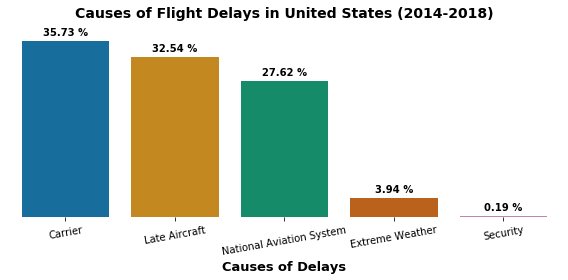

In [17]:
#data preparation for the plot
delay_causes = df_master[['pct_del_carrier', 'pct_del_weather', 'pct_del_nas', 'pct_del_security', 'pct_del_late']].mean().sort_values(ascending = False)
labels = ['Carrier', 'Late Aircraft', 'National Aviation System', 'Extreme Weather', 'Security']

#drawing the plot
plt.figure(figsize = [8, 4])
bplot = sns.barplot(x = delay_causes.index, y = delay_causes.values, palette = 'colorblind')

#plot decorations
plt.title('Causes of Flight Delays in United States (2014-2018)', fontsize = 14, weight = 'bold')
plt.xlabel('Causes of Delays', fontsize = 13, weight = 'bold')
plt.ylabel('Percentage (%)', fontsize = 13, weight = 'bold')
plt.xticks(range(0, 5), labels, rotation = 10)

for p in bplot.patches: # create the annotation on top of each bar
    bplot.annotate('{:.2f} %'.format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height() - 0.25), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', weight = 'bold')

frame1 = plt.gca() # makes the values in the y-axis invisible
frame1.axes.get_yaxis().set_visible(False)

bplot.spines['top'].set_visible(False) # Remove the borders in the plot
bplot.spines['right'].set_visible(False)
bplot.spines['bottom'].set_visible(False)
bplot.spines['left'].set_visible(False)

ttl = bplot.title
ttl.set_position([.5, 1.05])

plt.savefig('plot1.png');

And the answer is very tricky. In the figure above, a summary of the most common causes for delayed flights in the period of 2014-2018 in the United States are represented. As it can be noted, the most common reason for a delayed flight were delays due to **"Carrier"** (35.7%), situations within the airline's control (e.g. maintenance, crew problems, aircraft cleaning, baggage loading, fueling. On the other end, delays due to **"Security"** (delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas) were the least common with only 0.2 % of the flights being delayed for this reason. Although it seems that **"Extreme Weather"** was only responsible of the delay of approximately 4% of the flights during the studied period, a variable fraction of the delays under **"National Aviation System"** (delays and cancellations due to the national aviation system that refer to a varied set of situations, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control) and **"Late Aircraft"** (a previous flight using the same aircraft arrived late, causing the present flight to depart late) can also be attributed to milder weather events that result in delays.

**Why aren’t all weather-related delays reported as a single category ?** a committee named the *Air Carrier On-Time Reporting Advisory Committee* created the reporting system in use believing that keeping the extreme weather delays from the weather delays that could be fixed through improvements to the system, would give a more realistic picture of the extent of weather delays. Soooo, is it really the weather ??? I guess it depends, in some occassions when major weather events have occurred in some parts of the country, it is very feasible that a flight will be delayed, likely causing delays in the next flight and producing a chain reaction of delays. Being afraid to sound like a airline representative, I just advice you to be patient, do not scream, but always ask for coupons and credit if the delay gets too long. A little pressure never hurts to make things work better.

### This is the last time I am flying this airline !!!

You are already on board and you start seeing the light at the end of the tunnel, deep breath, and you suddenly say **THIS IS THE LAST TIME I FLY WITH THIS AIRLINE !!!** As much as you want this to be true, many factors are involved in deciding which airline to pick for your next journey and may be the following information can help you a little bit. A survey of the flight delays data available for the period between 2014 and 2018 indicates that on average 19.6% of the flights were delayed for reasons discussed in the previous section of this work. From that average proportion of delays during the 2014-2018 period, some airlines performed better than others.

**NOTE:** the following image and discussion does not try to predict performance of the airlines but rather illustrate the performance in terms of delays in the period specified

In [18]:
#data preparation for the plot
pct_delays_carrier = df_master.groupby('carrier_name')['pct_delayed_flights'].mean()
length_delays_carrier = df_master.groupby('carrier_name')['min_per_delay'].mean()
pct_delay_carrier = df_master.groupby('carrier_name')['pct_del_carrier'].mean()

df_by_carrier = pd.DataFrame() #empty dataframe and appending columns
df_by_carrier['pct_delays'] = pct_delays_carrier
df_by_carrier['avg_length_delay'] = length_delays_carrier
df_by_carrier['diff_pct_delays'] = df_by_carrier['pct_delays'] - 20
df_by_carrier['pct_del_carrier'] = pct_delay_carrier
df_by_carrier.sort_values(by='diff_pct_delays', ascending=True, inplace=True)

#color coding the records based on the difference of percentage of flight delays and the mean for all the airlines
df_by_carrier['colors'] = ['green' if x < 0 else 'red' for x in df_by_carrier['diff_pct_delays']]

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


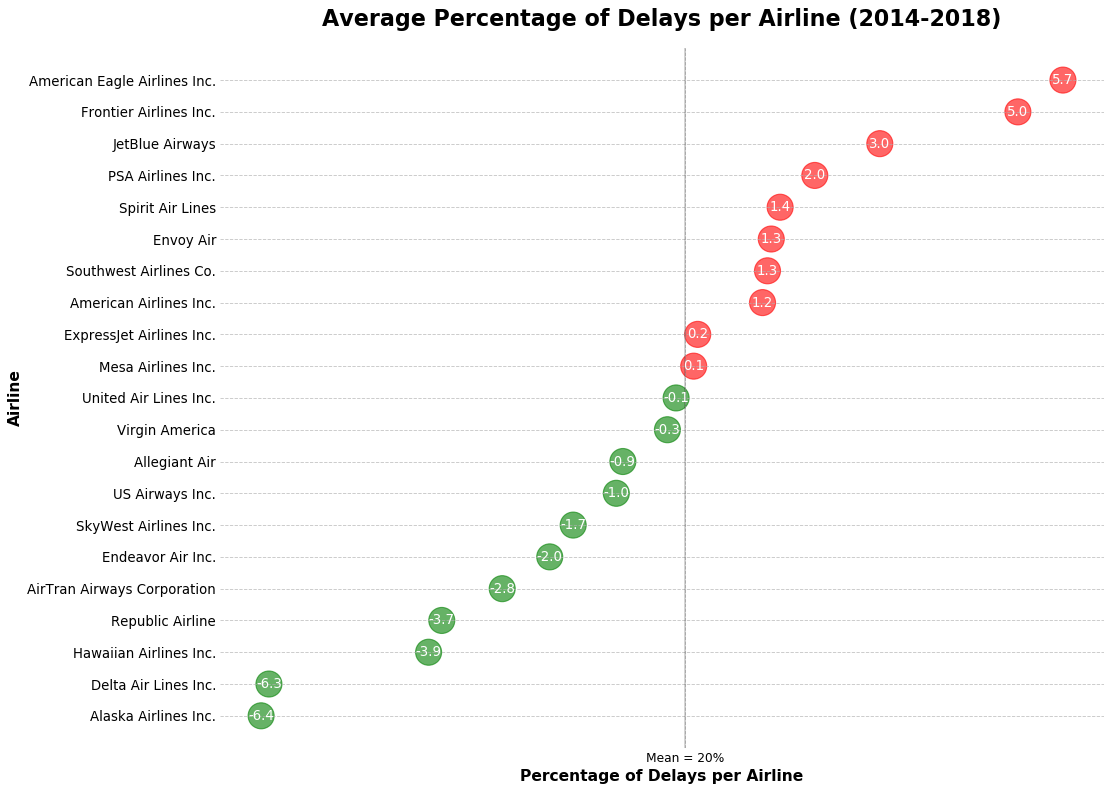

In [19]:
#drawing the plot
plt.figure(figsize=(14,10), dpi= 80)
plt.scatter(df_by_carrier['diff_pct_delays'], df_by_carrier.index, s=550, alpha=.6, color=df_by_carrier.colors)
for x, y, tex in zip(df_by_carrier['diff_pct_delays'], df_by_carrier.index, df_by_carrier['diff_pct_delays']):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':'white', 'size':12})

#plot decorations
plt.ylabel('Airline', fontsize=14, weight='bold') 
plt.xlabel('Percentage of Delays per Airline', fontsize=14, weight='bold')
plt.yticks(df_by_carrier.index, fontsize=12)
plt.title('Average Percentage of Delays per Airline (2014-2018)', fontdict={'size':20}, pad=20, weight='bold')
plt.xticks(np.arange(1), (['Mean = 20%']), fontsize=11)
plt.axvline(0, color='black', alpha=0.2)
plt.grid(linestyle='--', alpha=0.7)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

plt.savefig('plot2.png');

As it can be observed in the chart above, the carrier that reported the highest percentage of delays during the last five years was **American Eagle Airlines** (25.7%) followed by **Frontier Airlines** (25.02%) and **JetBlue Airways** (22.94%). However, to be fair **American Eagle Airlines** only reported data until mid 2014 when it changed its name to **Envoy Air** which is not in our top five list for the most delayed. The data for both carriers was kept separated since we had no certainty about the how the operations were affected after the change of name.

In contrast, the real winner is **Delta Air Lines**. Even not being the carrier reporting the lowest percentage of delayed flights, the massive number of flights carried on by the airline and the low percentage of delays reported (13.7%) makes it, in my opinion, the most reliable carrier in the group during 2014-2018.

### Does size matters ???

In a recent converstation with other angry-delayed travelers, I heard comments about how different airports and airlines seem to be more prone to delays than others based on the size of the operations they carry. In order to answer this question, the airlines were divided into two groups depending on the size of their operations throughout the period 2014-2018. The list below show the carriers from the largest number of flights to the smallest.

In [20]:
#aggregation of the data by airline based on total number of flights sorted in descending order
size = df_master.groupby('carrier_name')['total_flights'].sum().sort_values(ascending = False)
size

carrier_name
Southwest Airlines Co.          6443767.0
Delta Air Lines Inc.            4483772.0
American Airlines Inc.          3998069.0
SkyWest Airlines Inc.           3287977.0
United Air Lines Inc.           2767773.0
ExpressJet Airlines Inc.        2291412.0
JetBlue Airways                 1429264.0
Alaska Airlines Inc.             942125.0
Envoy Air                        883343.0
US Airways Inc.                  613380.0
Spirit Air Lines                 609311.0
Frontier Airlines Inc.           495048.0
Hawaiian Airlines Inc.           391688.0
Republic Airline                 316099.0
PSA Airlines Inc.                278457.0
Virgin America                   277184.0
Endeavor Air Inc.                246008.0
Mesa Airlines Inc.               215144.0
American Eagle Airlines Inc.      99989.0
Allegiant Air                     99677.0
AirTran Airways Corporation       79495.0
Name: total_flights, dtype: float64

In order to get a better idea about the what size of operations will serve as cutoff for creating the two groups, summary statistics were evaluated below, suggesting that operations larger than 600,000 flights during the last five years may be called 'large' while operations sizes below that number may be considered 'small'.

In [21]:
#estimation of cutoff to code carrier as 'large' or 'small' in terms of size of operations
df_master.groupby('carrier_name').total_flights.sum().sort_values(ascending = False).describe()

count    2.100000e+01
mean     1.440428e+06
std      1.774900e+06
min      7.949500e+04
25%      2.771840e+05
50%      6.093110e+05
75%      2.291412e+06
max      6.443767e+06
Name: total_flights, dtype: float64

In [22]:
#creation of new dataframe
df_size = pd.DataFrame()
df_size['carrier_name'] = size.index
df_size['total_flights_14-18'] = size.values

In [23]:
#coding airlines in terms of operation size ('total_flights_14-18')
df_size['carrier_size'] = np.where(df_size['total_flights_14-18'] > 600000, 'large', 'small')

In [24]:
pct_delays = df_master.groupby('carrier_name').pct_delayed_flights.mean().sort_values(ascending = False)
df_pct_delays = pd.DataFrame()
df_pct_delays['carrier_name'] = pct_delays.index
df_pct_delays['pct_delay_flights_14-18'] = pct_delays.values

df_size = df_size.merge(df_pct_delays, on = 'carrier_name')

min_delay = df_master.groupby('carrier_name').min_per_delay.mean().sort_values(ascending = False)
df_min_delay = pd.DataFrame()
df_min_delay['carrier_name'] = min_delay.index
df_min_delay['min_per_delay_14-18'] = min_delay.values

df_size = df_size.merge(df_min_delay, on = 'carrier_name')
df_size.head()

,carrier_name,total_flights_14-18,carrier_size,pct_delay_flights_14-18,min_per_delay_14-18
0,Southwest Airlines Co.,6443767.0,large,21.251390,49.569292
1,Delta Air Lines Inc.,4483772.0,large,13.705522,58.486721
2,American Airlines Inc.,3998069.0,large,21.176253,56.204636
3,SkyWest Airlines Inc.,3287977.0,large,18.310551,64.117541
4,United Air Lines Inc.,2767773.0,large,19.868043,63.327584


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


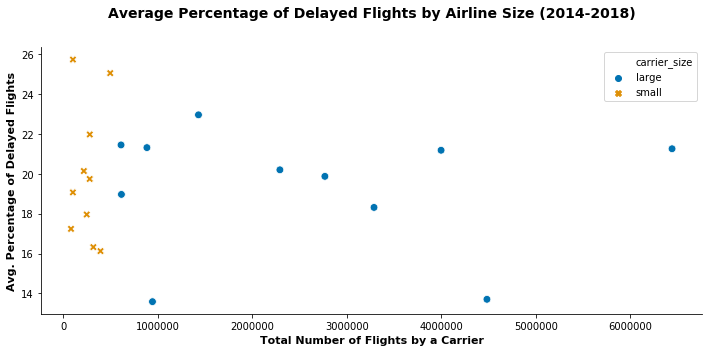

In [25]:
#drawing the plot
plt.figure(figsize = [10, 5])
size_plot = sns.scatterplot(data=df_size, y = 'pct_delay_flights_14-18', x ='total_flights_14-18', hue ='carrier_size', style='carrier_size', palette = 'colorblind', s = 60, legend='full')

#plot decorations
plt.title('Average Percentage of Delayed Flights by Airline Size (2014-2018)', fontsize = 14, weight = 'bold', pad=30)
plt.xlabel('Total Number of Flights by a Carrier', fontsize = 11, weight = 'bold')
plt.ylabel('Avg. Percentage of Delayed Flights', fontsize = 11, weight = 'bold')

size_plot.spines['right'].set_visible(False)
size_plot.spines['top'].set_visible(False)
plt.savefig('plot3.png');

In the plot above, it can be observed that the scale or size of the operations of a carrier does not imply a higher percentage of delayed flights. Actually, the airlines that reported the lowest percentages of delayed flights (below 14%) between years 2014 and 2018 were airlines with large operations (above 1,000,000 flights in the last five years). In constrast, the two carriers that reported the highest percentage of delayed flights (approximately 25% and above) were airlines with number of flights below the 500,000 flights in the last five years. Based on this information, it seems that there is not enough evidence to support choosing an airline based on size of its operations when worrying about delays. Many other reasons are typically behind deciding what airline to choose like cost, scheduling options, etc, but do not tell me it would not be awesome to know how likely is your flight to be delayed when purchasing the ticket. 

For many people such a prediction will need, to the very least, an astrologist or car reader, **BUT KEEP AN EYE ON THE NEWS...MACHINE LEARNING AND ARTIFICIAL INTELLIGENCE ARE HERE TO STAY**

### References

- The original data used for this work was manually downloaded from the United States Department of Transportation website hosted under the following link: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1.

- Appropriate description of the original fields can be found in https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations

- In occassions, the documentation available for the Python's libraries used in this work and certain built-in functions was accessed through the internet 